In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import random   

In [6]:
class ES(): #here fitness has to be a function that scores all population at once
    def __init__(self, domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=False):
        assert population_size <= offspring_size
        if type(domain) is tuple:
            self.domain = np.array([domain] * dim)
        else:
            self.domain = np.array(domain)

        self.dim = dim
        self.mu = population_size
        self.lam = offspring_size
        lr = 1
        self.tau0, self.tau = lr/np.sqrt(2 * np.sqrt(self.dim)), lr/np.sqrt(2*self.dim)
        self.fitness = fitness
        self.max_iter = max_iter
        self.plus = plus
        if parent_random:
            self.parent_selection = self.parent_selection_random
        else:
            self.parent_selection = self.parent_selection_roulette

    def initial_individual(self):
        x = np.random.uniform(self.domain[:,0], self.domain[:,1], size=self.dim)
        sigma = np.random.uniform(3, 8, size=self.dim)

        return np.vstack((x, sigma))

    def random_individual(self):
        x = np.random.uniform(self.domain[:,0], self.domain[:,1], size=self.dim)
        sigma = np.random.uniform(0.5, 1.5, size=self.dim)

        return np.vstack((x, sigma))

    def generate_population(self, initial=False):
        P = []
        for _ in range(self.mu):
            if initial:
                P.append(self.initial_individual())
            else:
                P.append(self.random_individual())
        P = np.array(P)
        return np.array(P)

    def mutate(self, P):
        xs, sigmas = P[:, 0], P[:, 1]
        assert type(sigmas) == np.ndarray
        mutated = []

        for i in range(len(P)):
            eps0 = np.random.normal(0, self.tau0**2)
            eps = np.random.normal(0, self.tau**2)
            multiplier = np.exp(eps0 + eps)
            
            new_sigma = sigmas[i] * multiplier

            new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
            its = 0
            while (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])) and its < 4:
                its += 1
                new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
            if (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])):
                new_x, new_sigma = self.random_individual()
            
            mutated.append(np.vstack((new_x, new_sigma)))
            
        return np.array(mutated)

    def replacement(self, P, P_costs, pc, pc_costs):
        if(self.plus):
            combined = np.concatenate((P, pc), axis=0)
            assert combined.shape == (self.mu + self.lam, 2, self.dim), f"{combined.shape}"
            combined_scores = np.concatenate((P_costs, pc_costs))
            indices = np.argsort(combined_scores)
            assert combined_scores[indices[0]] <= combined_scores[indices[-1]]
            P = combined[indices[:self.mu]]
        else:
            scores = self.fitness(pc)
            indices = np.argsort(scores)
            P = pc[indices[:self.mu]]
        return P

    def parent_selection_random(self, P, score):
        return P[np.random.choice(len(P), self.lam, replace=True)]

    def parent_selection_roulette(self, P, score):
        if np.min(score) == np.max(score):
            idxs = np.random.choice(len(P), size=self.lam, replace=True)
        else:
            std_costs = (score - np.min(score)) / (score - np.min(score)).max()
            p_costs = (1 - std_costs)
            idxs = np.random.choice(len(P), p=p_costs / sum(p_costs), size=self.lam, replace=True)
        return P[idxs].copy()

    def run(self):
        P = self.generate_population(initial=True)
        assert P.shape == (self.mu, 2, self.dim) 
        score = self.fitness(P)
        best_score = np.min(score)
        best_individual = P[np.argmin(score)]

        iter_min, iter_mean, iter_max = [], [], []
        range_ = trange(int(self.max_iter), position=0, leave=True)
        try:
            for _iter in range_:
                parents = self.parent_selection(P, score)
                assert parents.shape == (self.lam, 2, self.dim)

                mutation = self.mutate(parents)
                assert mutation.shape == (self.lam, 2, self.dim)

                P = self.replacement(P, score, mutation, self.fitness(mutation))
                assert P.shape == (self.mu, 2, self.dim), f'{P.shape}'

                score = self.fitness(P)

                min_score_index = np.argmin(score)
                min_score = np.min(score)
                if min_score < best_score:
                    best_score = min_score
                    best_individual = P[min_score_index]
                
                # print(f'Iter: {_iter}, best: {best_score}')
                iter_min.append(best_score)
                iter_mean.append(np.mean(score))
                iter_max.append(np.max(score))
        except KeyboardInterrupt:
            pass

        return best_individual, best_score, iter_min, iter_mean, iter_max


In [7]:
def showcase(best_individual, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima):
    print(f'Best individual: {best_individual[0]}')
    print(f'Best score: {best_score}')
    iter_min = np.array(iter_min)
    iter_min = iter_min[iter_min < 1e8]
    # iter_mean = np.array(iter_mean)
    # iter_mean = iter_mean[iter_mean < 1e8]
    # plt.plot(iter_mean, label='mean')
    plt.plot(iter_min, label='min')
    global_minima_array = np.full(len(iter_min), global_minima)
    plt.plot(global_minima_array, label='min_global', color='r')
    plt.legend()
    plt.title(problem_name)
    plt.show()

def ESPlusRandom(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=True, parent_random=True)
    best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESPlusRoulette(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=True, parent_random=False)
    best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESCommaRandom(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=True)
    best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESCommaRoulette(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=False)
    best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

In [12]:
def g1p(population):
    g1v = np.array([2*x[0] + 2*x[1] + x[9] + x[10] - 10 for x in population[:, 0]])
    g2v = np.array([2*x[0] + 2*x[2] + x[9] + x[11] - 10 for x in population[:, 0]])
    g3v = np.array([2*x[1] + 2*x[2] + x[10] + x[11] - 10 for x in population[:, 0]])
    g4v = np.array([-8*x[0] + x[9] for x in population[:, 0]])
    g5v = np.array([-8*x[2] + x[11] for x in population[:, 0]])
    g6v = np.array([-8*x[2] + x[11] for x in population[:, 0]])
    g7v = np.array([-2*x[3] - x[4] + x[9] for x in population[:, 0]])
    g8v = np.array([-2*x[5] - x[6] + x[10] for x in population[:, 0]])
    g9v = np.array([-2*x[7] - x[8] + x[11] for x in population[:, 0]])
    
    costs = np.array([5*sum(x[:4]) - 5*sum(x[:4]**2) - sum(x[4:]) for x in population[:,0]])
    not_good_constrains = np.sum(np.vstack((g1v > 0, g2v > 0, g3v > 0, g4v > 0, g5v > 0, g6v > 0, g7v > 0, g8v > 0, g9v > 0)), axis=0)
    costs += 1e10 * not_good_constrains
    
    return costs

dims = 13
domain = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 100), (0, 100), (0, 100), (0, 1)]
initial_population = 4000
offspring_size = 21000
max_iters = 400
global_minima = -15

100%|██████████| 1000/1000 [10:59<00:00,  1.52it/s]

Best individual: [1.00000000e+00 3.81636255e-16 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.60038116e-01 5.01615858e-01 1.00000000e+00
 1.00000000e+00 2.30985507e+00 1.14321139e+00 3.00000000e+00
 9.81894428e-01]
Best score: -11.896614866109516


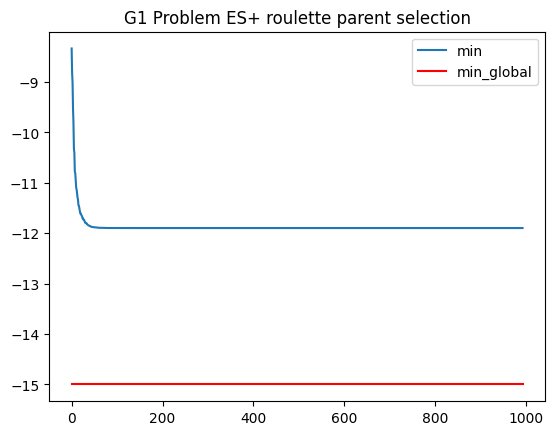

In [11]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, g1p, max_iters, 'G1 Problem ES+ roulette parent selection', global_minima)

100%|██████████| 400/400 [06:33<00:00,  1.02it/s]

Best individual: [1.         1.         1.         1.         1.         1.
 0.99997736 0.84644614 0.99999999 1.84799076 1.11957288 2.6265732
 0.94105687]
Best score: -11.38161719947354


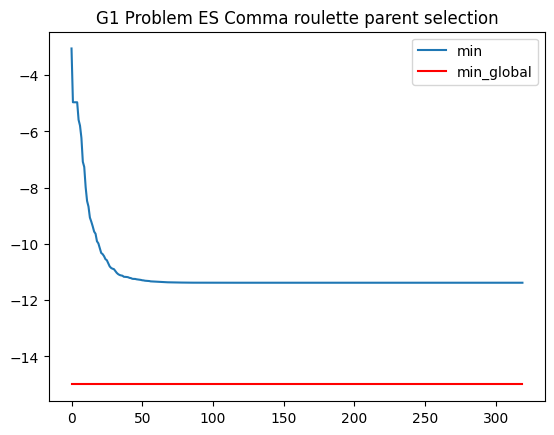

In [13]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, g1p, max_iters, 'G1 Problem ES Comma roulette parent selection', global_minima)

In [14]:
def g2p(population):
    dims = population.shape[-1]
    g1v = np.array([-np.prod(x) + 0.75 for x in population[:,0]])
    g2v = np.array([np.sum(x) - 7.5*len(x) for x in population[:,0]])
    costs = - np.abs(np.array([((np.cos(x)**4).sum() - 2*np.prod(np.cos(x)**2)) / \
                               np.sqrt((x**2 * np.arange(1, dims+1)).sum()) 
                               for x in population[:,0]]))
    
    not_good_constrains = np.sum(np.vstack((g1v > 0, g2v > 0)), axis=0)
    costs += 1e10 * not_good_constrains
    
    return costs

dims = 20
domain = (0, 10)
initial_population = 4000
offspring_size = 21000
max_iters = 400
global_minima = -0.803619

100%|██████████| 400/400 [04:20<00:00,  1.54it/s]

Best individual: [3.15681767 3.14005111 0.36200859 3.09805521 0.35487596 3.07504884
 0.35225402 3.0406642  0.35163059 3.00543224 0.3475902  0.34606407
 2.95005095 0.34798686 1.38051273 0.34137691 0.34087468 2.84240742
 2.87740605 0.33662813]
Best score: -0.5982853792377469


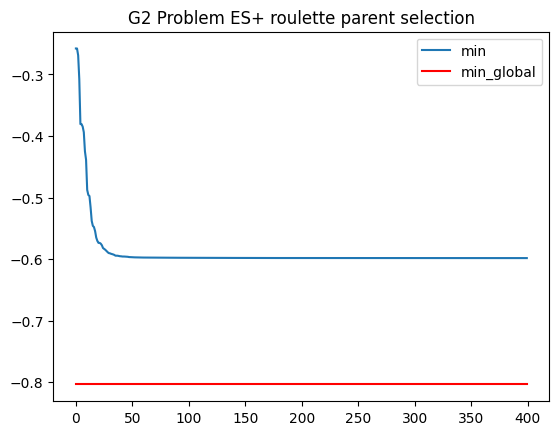

In [15]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, g2p, max_iters, 'G2 Problem ES+ roulette parent selection', global_minima)

100%|██████████| 400/400 [05:38<00:00,  1.18it/s]

Best individual: [6.25919592 3.13417103 0.42566951 3.09194763 3.06858733 3.04539499
 3.05906991 0.41412181 2.96938425 0.4033317  0.40127218 0.40337926
 0.39820554 0.39657154 1.33242608 2.64365264 0.39128367 0.38995552
 0.38351377 0.38884175]
Best score: -0.684728707743055


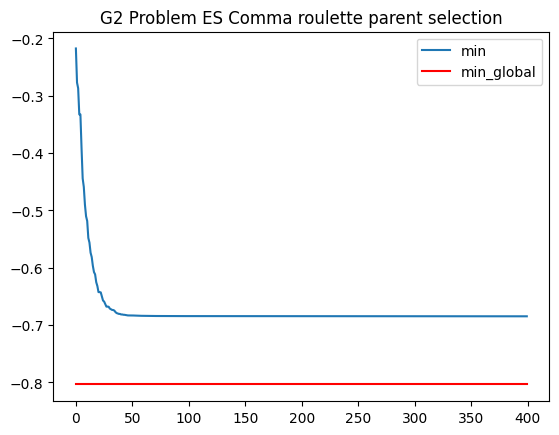

In [16]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, g2p, max_iters, 'G2 Problem ES Comma roulette parent selection', global_minima)

In [17]:
def g6p(population):
    costs = [(x[0] - 10)**3 + (x[1]-20)**3 for x in population[:,0]]
    
    g1v = np.array([-(x[0]-5)**2 - (x[1] - 5)**2 + 100 for x in population[:,0]])
    g2v = np.array([(x[0]-6)**2 + (x[1] - 5)**2 - 82.81 for x in population[:,0]])
    
    not_good_constrains = np.sum(np.vstack((g1v > 0, g2v > 0)), axis=0)
    costs += 1e10 * not_good_constrains
    
    return costs

dims = 2
domain = [(13, 100), (0, 100)]
initial_population = 4000
offspring_size = 21000
max_iters = 400
global_minima = -6961.81388

100%|██████████| 400/400 [02:42<00:00,  2.46it/s]

Best individual: [14.095       0.84296079]
Best score: -6961.8138755801665


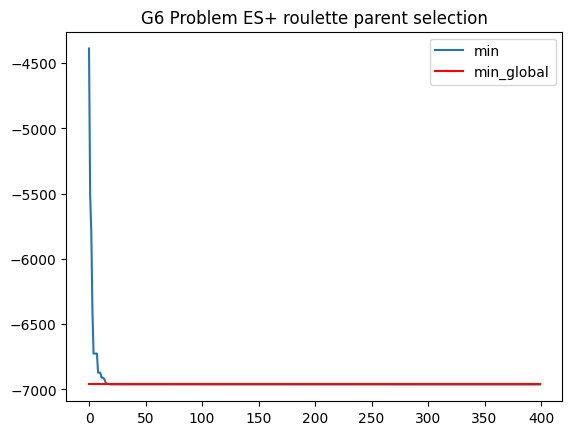

In [18]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, g6p, max_iters, 'G6 Problem ES+ roulette parent selection', global_minima)

100%|██████████| 400/400 [02:52<00:00,  2.32it/s]

Best individual: [14.095       0.84296079]
Best score: -6961.8138755801665


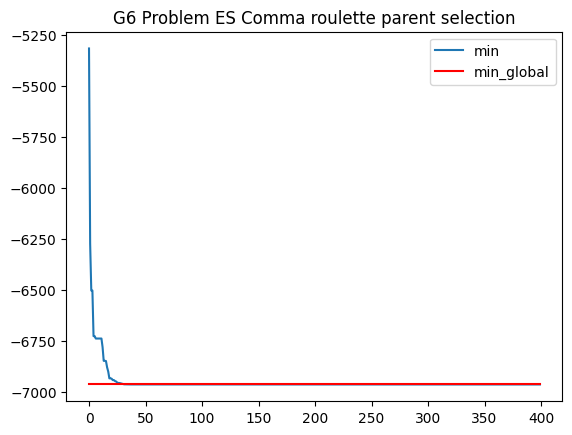

In [19]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, g6p, max_iters, 'G6 Problem ES Comma roulette parent selection', global_minima)

In [20]:
def g8p(population):
    costs = - np.array([np.sin(2*np.pi * x[0])**3 * np.sin(2*np.pi * x[1]) / (x[0]**3 * (x[0]+x[1])) 
                        for x in population[:,0]])
    g1v = np.array([x[0]**2 - x[1] + 1 for x in population[:,0]])
    g2v = np.array([1-x[0] + (x[1]-4)**2 for x in population[:,0]])
    
    not_good_constrains = np.sum(np.vstack((g1v > 0, g2v > 0)), axis=0)
    costs += 1e10 * not_good_constrains
    
    return costs

dims = 2
domain = (0, 10)
initial_population = 4000
offspring_size = 21000
max_iters = 400
global_minima = -0.095825

100%|██████████| 400/400 [02:54<00:00,  2.30it/s]

Best individual: [1.22797135 4.24537337]
Best score: -0.09582504141803587


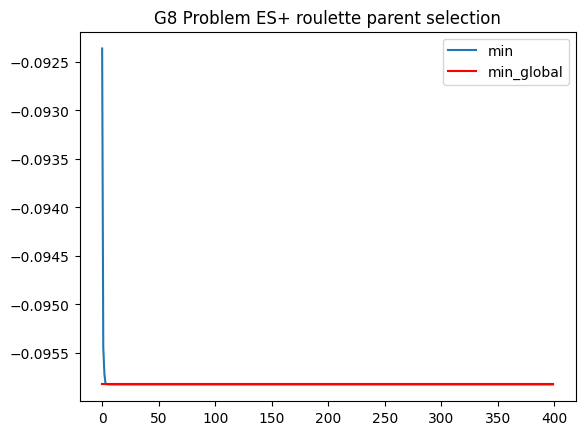

In [21]:
ESPlusRoulette(domain, dims, initial_population, offspring_size, g8p, max_iters, 'G8 Problem ES+ roulette parent selection', global_minima)

100%|██████████| 400/400 [03:12<00:00,  2.08it/s]

Best individual: [1.22797135 4.24537337]
Best score: -0.09582504141803587


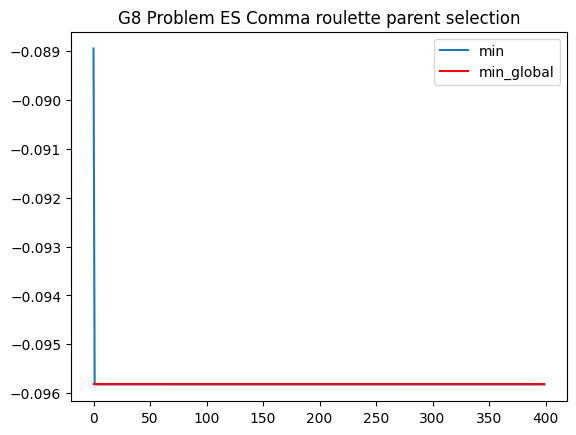

In [22]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, g8p, max_iters, 'G8 Problem ES Comma roulette parent selection', global_minima)

In [26]:
def g10p(population):
    costs = np.array([x[0]+x[1]+x[2] for x in population[:,0]])
    
    g1v = np.array([-1 + 0.0025*(x[3] + x[5]) for x in population[:,0]])
    g2v = np.array([-1 + 0.0025*(-x[3] + x[4] + x[6]) for x in population[:,0]])
    g3v = np.array([-1 + 0.01*(-x[4] + x[7]) for x in population[:,0]])
    g4v = np.array([100*x[0] - x[0]*x[5] + 833.33242*x[3] - 83333.333 for x in population[:,0]])
    g5v = np.array([x[1]*x[3] - x[1]*x[6] - 1250*x[3] + 1250*x[4] for x in population[:,0]])
    g6v = np.array([x[2]*x[4] - x[2]*x[7] - 2500*x[4] + 1250000 for x in population[:,0]])
    
    not_good_constrains = np.sum(np.vstack((g1v > 0, g2v > 0, g3v > 0, g4v > 0, g5v > 0, g6v > 0)), axis=0)
    costs += 1e10 * not_good_constrains
    
    return costs


dims = 8
domain = [(100, 10000), (1000, 10000), (1000, 10000), (10, 1000), (10, 1000), (10, 1000), (10, 1000), (10, 1000)]
initial_population = 4000
offspring_size = 21000
max_iters = 1000
global_minima = 7049.330

100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s]

Best individual: [4037.22408389 1000.25486785 4398.00748595  265.26255908  325.06370717
  134.13366383  340.01855734  424.83641832]
Best score: 9435.486437678024


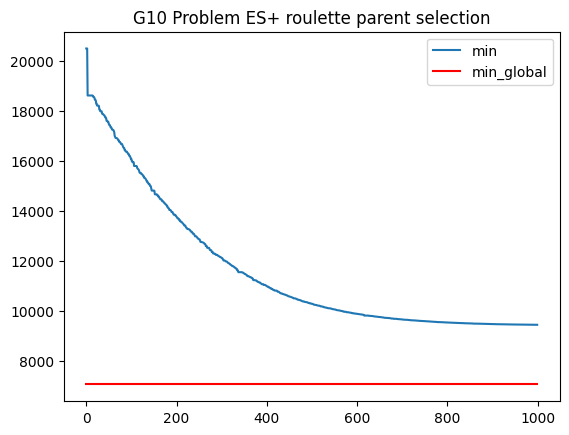

In [27]:
ESPlusRandom(domain, dims, initial_population, offspring_size, g10p, max_iters, 'G10 Problem ES+ roulette parent selection', global_minima)

100%|██████████| 1000/1000 [09:19<00:00,  1.79it/s]

Best individual: [ 100.00102284 1000.0009494  6422.63782726  117.57755855  243.097135
  246.49480776  274.47824891  343.09677154]
Best score: 7522.639799507135


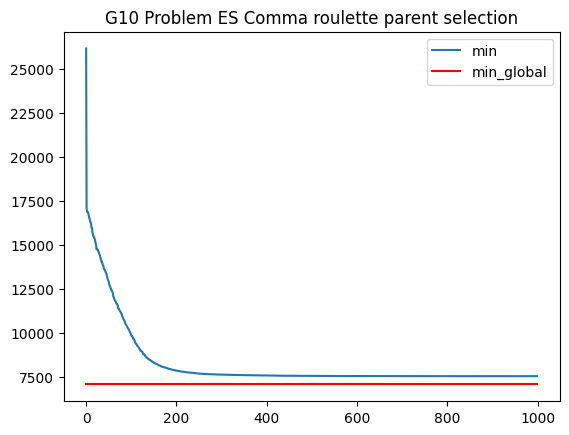

In [28]:
ESCommaRoulette(domain, dims, initial_population, offspring_size, g10p, max_iters, 'G10 Problem ES Comma roulette parent selection', global_minima)